# Simulering av plasttransport i havet

I dette prosjektet utfører vi simulering av plasttransport i havet ved å løse differensialligninger med Heuns metode. For å gjøre dette, bruker vi analytiske uttrykk for hastighetsfelt, og beregninger av partikkelbaner basert på relle strøm- og vinddata. Formålet med prosjektet er å bruke numeriske metoder for å studere og løse fysikkrelaterte problemstillinger. Vi vil også se på hvordan ulike faktorer påvirker resultatene av simuleringene, som steglengde i metoden, antall plastpartikler, vind- og strømforhold, samt stranding av partikler.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
import xarray as xr
from scipy.interpolate import RectBivariateSpline
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

### Oppgave 1a

Vi starter med å se på én partikkel i et gitt analytisk vektorfelt, med startposisjon $\textbf{x}_0 = [1.05, 0.5]$, med bruk av Heuns metode. Vi plotter partikkelbanen for ulike verdier av steglengden $h$, for så å se hvilken steglengde som er rimelig kort. Videre diskuterer vi om valgt steglengde er tilstrekkelig når vi dobler integrasjonstiden.

In [2]:
# Definerer konstanter
A = 0.1
epsilon = 0.25 
w = 1 # omega

# Definerer fartsfunksjonen
def f(x,t):
    a_t = epsilon * np.sin(w * t)
    b_t = 1 - 2 * epsilon * np.sin(w * t)

    f_x_t = a_t * x[:,0] ** 2 + b_t * x[:,0]

    vx = - np.pi * A * np.sin(np.pi * f_x_t) * np.cos(np.pi* x[:,1])
    vy = np.pi * A * np.cos(np.pi * f_x_t) * np.sin(np.pi * x[:,1]) * (2 * a_t * x[:,0] + b_t)

    bane = np.column_stack((vx,vy))

    return bane

Inputen $\textbf{x}$ i fartsfunksjonen $f$ har dimensjon $(1, N_p, 2)$, og ser slik ut: $
\begin{bmatrix}
    \begin{bmatrix}
        x & y
    \end{bmatrix}_{1}
    &
    \cdots
    &
    \begin{bmatrix}
        x & y
    \end{bmatrix}_{N_p}
    \\
\end{bmatrix}_{t_0}.
$

Videre implementeres Heun's metode. Denne fungerer for både en og flere partikler. Outputen x_array fra $heun1()$ vil bli seende slik ut:

<center>

$
\Big[
\begin{bmatrix}
    \begin{bmatrix}
        x & y
    \end{bmatrix}_{1}
    &
    \cdots 
    &
    \begin{bmatrix}
        x & y
    \end{bmatrix}_{N_p}
    \\
\end{bmatrix}_{t_0}
\\
\hspace{2.5cm}\vdots
\\
\begin{bmatrix}
    \begin{bmatrix}
        x & y
    \end{bmatrix}_{1}
    &
    \cdots 
    &
    \begin{bmatrix}
        x & y
    \end{bmatrix}_{N_p}
    \\
\end{bmatrix}_{t_{end}}
\Big].$

<center>

In [3]:
def heun1(x0, t0, t_end, f, h):
    '''
    Heuns metode for å løse x' = f(x,t), x(t0) = x0
    '''
    if not isinstance(x0, np.ndarray): # dersom det skulle oppstå et skalarproblem: 
        x0 = np.array([x0])            # konverterer x0 til et numpy array
    if x0.size == 2:           # dersom det bare er en partikkel:
        x0 = np.array([x0])    # oppretter et 2D-array for x der x0 er første element         
    
    t_array = np.arange(t0, t_end+0.0001, h)      # oppretter et 1D-array for t ∈ [t0, t_end]

    num_steps = len(t_array)    # henter størrelser som skal benyttes under
    Np = len(x0)

    x_array = np.zeros((num_steps+1, Np, 2))    # oppretter et 3D-array for x   
    x_array[0,:,:] += x0                        # der x0 er første element

    for i in range(num_steps):
        t = t_array[i]        # henter verdien fra t-arrayet for dette steget 
        x = x_array[i,:,:]    # henter riktig element i x-arrayet, dvs. et array med Np x- og y-koordinater
        
        k1 = f(x,t)                      # utfører Heuns metode       
        k2 = f(x + h*k1, t+h)
        x_ny = x + 0.5 * h * (k1 + k2)

        x_array[i+1, :, :] += x_ny   # legger til den nye verdien i x-arrayet langs første akse

    return t_array, x_array

Beregner banen til en partikkel med initialposisjon $\textbf{x}_0 = [1.05, 0.5]$ i tidsintervallet $t \in [0, 50]$ ved hjelp av Heuns metode ved ulike steglengder $h$. Plotter banene for hver steglengde. Gjør deretter tilsvarende med $t \in [0, 100]$.

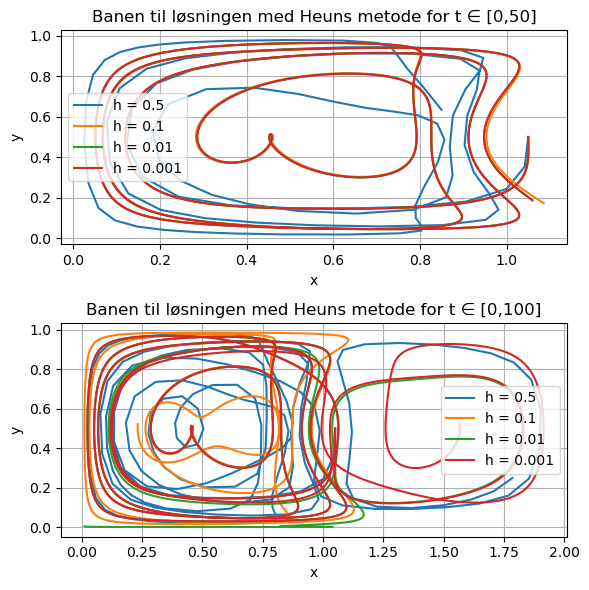

In [4]:
# Initialbetingelse
x0 = np.array([1.05, 0.5])

# Tidsintervall
t0 = 0
t_end = 50

# Ulike steglengder
h1 = 0.5
h2 = 0.1
h3 = 0.01
h4 = 0.001

# Henter resultater for ulike steglengder h for t ∈ [0,50]
t_sol1, x_sol1 = heun1(x0, t0, t_end, f, h1)
t_sol2, x_sol2 = heun1(x0, t0, t_end, f, h2)
t_sol3, x_sol3 = heun1(x0, t0, t_end, f, h3)
t_sol4, x_sol4 = heun1(x0, t0, t_end, f, h4)

# Henter resultater for ulike steglengder h for t ∈ [0,100]
t_sol5, x_sol5 = heun1(x0, t0, 100, f, h1)
t_sol6, x_sol6 = heun1(x0, t0, 100, f, h2)
t_sol7, x_sol7 = heun1(x0, t0, 100, f, h3)
t_sol8, x_sol8 = heun1(x0, t0, 100, f, h4)

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6,6))

# Plotter resultatene for t ∈ [0,50]
axs[0].plot(x_sol1[:,:,0], x_sol1[:,:,1], label = f"h = {h1}")  # x_sol[:,0] gir x-koordinatene, x_sol[:,1] gir y-koordinatene
axs[0].plot(x_sol2[:,:,0], x_sol2[:,:,1], label = f"h = {h2}")
axs[0].plot(x_sol3[:,:,0], x_sol3[:,:,1], label = f"h = {h3}")
axs[0].plot(x_sol4[:,:,0], x_sol4[:,:,1], label = f"h = {h4}")
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_title('Banen til løsningen med Heuns metode for t ∈ [0,50]')
axs[0].grid(True)
axs[0].legend()

# Nytt plot, med t ∈ [0,100]
axs[1].plot(x_sol5[:,:,0], x_sol5[:,:,1], label = f"h = {h1}")
axs[1].plot(x_sol6[:,:,0], x_sol6[:,:,1], label = f"h = {h2}")
axs[1].plot(x_sol7[:,:,0], x_sol7[:,:,1], label = f"h = {h3}")
axs[1].plot(x_sol8[:,:,0], x_sol8[:,:,1], label = f"h = {h4}")
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].set_title('Banen til løsningen med Heuns metode for t ∈ [0,100]')
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()

I plottene over er løsningens bane plottet for ulike tidssteg $h$. I det øverste plottet, for $t \in [0,50]$, gir $h = 0.1, 0.01$ og $0.001$ veldig like resultater. I dette tilfellet konkluderer vi med at $h = 0.1$ er en tilstrekkelig liten steglengde. 

I det nederste plottet, for $t \in [0,100]$, kan man se at $h = 0.1$ avviker i større grad fra $h = 0.01$ og $0.001$. Altså er $h = 0.1$ ikke et tilstrekkelig valg når integrasjonstiden er doblet. $h = 0.001$ tar en del lengre tid å kjøre enn $h = 0.01$, og det ser ut til at $h = 0.01$ er tilstrekkelig. Vi konkluderer dermed med at $h = 0.01$ er en tilstrekkelig liten steglengde $t \in [0,100]$.

### Oppgave 1b

Vi ønsker å plotte banen til flere partikler med ulike startposisjoner i intervallet $t \in [0,10]$ ved hjelp av Heuns metode. Her markerer vi start- og sluttposisjonene, samt banen partiklene følger.

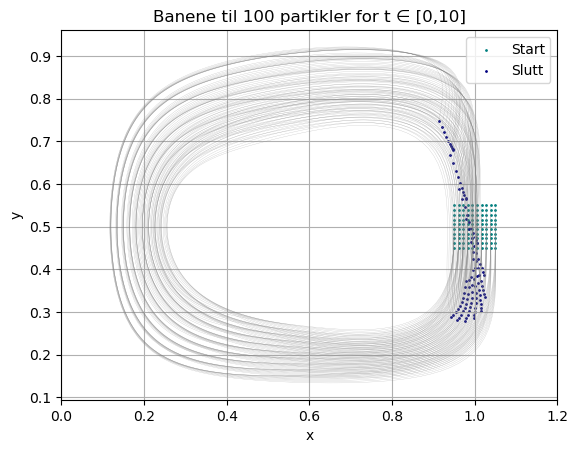

In [5]:
Np = 100      # antall initialverdier, dvs antall partikler

# Genererer initialverdiene jevnt med linspace
x_initial = np.linspace(0.95, 1.05, 10)  # får 10 x-verdier
y_initial = np.linspace(0.45, 0.55, 10)  # og 10 y-verdier

# Genererer et grid
x0, y0 = np.meshgrid(x_initial, y_initial)                           # blir to 10 * 10 grids
init = np.column_stack(( x0.reshape((Np,1)), y0.reshape((Np,1)) ))   # blir et (100, 2)-array

# Parametere
t0 = 0
t_end = 10
h = 0.1 

# Regner ut banene
baner = heun1(init, t0, t_end, f, h)[1]    # returnerer x_array'et fra heun()

# Plotter banene                
plt.plot(baner[:,:,0], baner[:,:,1], alpha = 0.5, lw = 0.2, color = "grey")   # henter posisjonene x og y og plotter

# Plotter start og sluttpunktene
plt.scatter(baner[0,:,0], baner[0,:,1], label="Start", color="teal", s=1)         # startposisjoner
plt.scatter(baner[-1,:,0], baner[-1,:,1], label="Slutt", color="navy", s=1)       # sluttposisjoner

plt.xlim(0, 1.2)  # angir bredden på plottet
plt.xlabel('x')
plt.ylabel('y')
plt.title('Banene til 100 partikler for t ∈ [0,10]')
plt.legend()
plt.grid(True)
plt.show()

Fra plottet ser vi at partiklene følger samme strømlinjer som banene som ble plottet i oppgave $1a$.

### Oppgave 1c

Ønsker å teste kjøretiden for ulike mengder partikler, $N_p$. Plotter kjøretiden som funksjon av $N_p$.

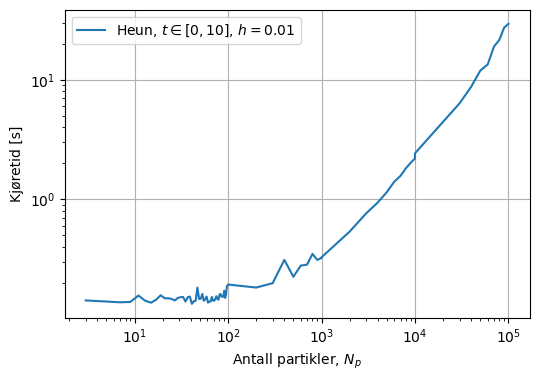

In [6]:
# Oppretter en liste som skal fylles med kjøretider for ulike verdier for Np
runtimes = []  

# Verdiene av Np vi vil teste
Np_vals1 = np.arange(3, 100, 2)
Np_vals2 = np.arange(100, 1001, 100)
Np_vals3 = np.arange(1000, 10001, 1000)
Np_vals4 = np.arange(10000, 100001, 10000)
Np_values = np.concatenate((Np_vals1, Np_vals2, Np_vals3, Np_vals4))  # samler alle verdiene for Np i et array

# Definerer konstanter
t0 = 0
t_end = 10
h = 0.01

for Np in Np_values:   
    # Oppretter tilfeldige startposisjoner for X
    X = np.zeros((Np, 2))         
    X[:,0] = np.random.rand(Np)
    X[:,1] = np.random.rand(Np)

    # Beregner kjøretiden 
    start_time = time()
    t, x_trajectory = heun1(X, t0, t_end, f, h)
    end_time = time()
    runtime = end_time - start_time
    runtimes.append(runtime)

# Plotter
plt.figure(figsize=(6,4))
plt.plot(Np_values, runtimes, label = 'Heun, $t\in[0,10]$, $h=0.01$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Antall partikler, $N_p$')
plt.ylabel('Kjøretid [s]')
plt.grid(True)
plt.legend()
plt.show()

Ovenfor kan man se kjøretiden som funksjon av antall partikler. Vi har valgt å plotte for noen utvalgte kjøretider ettersom målet er å se tendensen til utviklingen. Dette gjør plottet enklere å lese, og er i tillegg tidsbesparende.

Det kan se ut til at for relativt få partikler (små $N_p$) vil antall iterasjoner i Heuns metode ha mest å si for kjøretiden. Det tyder også på at variasjonen i tidsbruk for små verdier for $N_p$ har med implementasjonen av metoden og datamaskinens beregninger å gjøre. For mange partikler blir kjøretiden tilnærmet lineær. Arrayene med partikkelposisjonene blir så store at de vil påvirke kjøretiden, og matriseoperasjonene for hver iterasjon ser ut til å påvirke kjøretiden mest.

### Oppgave 2


Nedenfor inkluderer vi den utdelte koden, som brukes til videre oppgaveløsing.

In [7]:
%matplotlib inline
%load_ext line_profiler

#################################################
#### Praktisk klasse for å lese datafiler ####
#################################################

class Interpolator():
    def __init__(self, dataset, fw = 0.03):
        # xarray dataset objekt
        self.dataset = dataset
        # Vindfaktor
        self.fw = fw
        # Hent tidsstemplene som antall sekunder etter starten av filen
        # Spar litt arbeid med håndtering av np.datetime-objekter andre steder
        self.times = np.array([(t - self.dataset.time[0])/np.timedelta64(1, 's') for t in self.dataset.time[:]], dtype=np.float64)
        self.depth = np.array(self.dataset.h)
        
    def get_interpolators(self, X, it):
        # Legg til en buffer av celler rundt omfanget av partikkel-skyen
        buf  = 10
        # Finn omfanget av partikkel-skyen i form av indekser
        imax = np.searchsorted(self.dataset.X, np.amax(X[0,:])) + buf
        imin = np.searchsorted(self.dataset.X, np.amin(X[0,:])) - buf
        jmax = np.searchsorted(self.dataset.Y, np.amax(X[1,:])) + buf
        jmin = np.searchsorted(self.dataset.Y, np.amin(X[1,:])) - buf
        # Ta ut delsett av arrayen for å sende til
        # interpolasjon objektet
        # Fyll NaN-verdier (landceller) med 0, ellers
        # vil ikke interpolasjon fungere
        u_current = self.dataset.u[it, 0, jmin:jmax, imin:imax].T.fillna(0.0)
        v_current = self.dataset.v[it, 0, jmin:jmax, imin:imax].T.fillna(0.0)
        u_wind    = self.dataset.Uwind[it, jmin:jmax, imin:imax].T.fillna(0.0)
        v_wind    = self.dataset.Vwind[it, jmin:jmax, imin:imax].T.fillna(0.0)
        # RectBivariateSpline returnerer i hovedsak en funksjon,
        # som kan kalles for å få verdien på vilkårlig posisjon
        fu_current = RectBivariateSpline(self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], u_current)
        fv_current = RectBivariateSpline(self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], v_current)
        fu_wind    = RectBivariateSpline(self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], u_wind)
        fv_wind    = RectBivariateSpline(self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], v_wind)
        return fu_current, fv_current, fu_wind, fv_wind
        
    
    def get_time_index(self, t):
        # Få indeksen til det største tidsstempelet mindre enn (eller lik) t
        return np.searchsorted(self.times, t, side='right') - 1
    
    def on_land(self, X): # Returnerer True for partiklene som er på land
        # Finn indekser for hver partikkel
        ix_list = np.searchsorted(self.dataset.X, X[0,:])
        iy_list = np.searchsorted(self.dataset.Y, X[1,:])
        # Identifiser hvilke partikler som er i celler med dybde 5
        # (som av en eller annen grunn er den minste dybden)
        return np.array([self.depth[iy,ix] == 5.0 for ix, iy in zip(ix_list, iy_list)])

    def __call__(self, X, t):
        # Få indeksen til gjeldende tidspunkt i datasettet
        it = self.get_time_index(t)
        # Få interpoleringsfunksjoner,
        # som dekker omfanget av partikkelen
        fu_current, fv_current, fu_wind, fv_wind = self.get_interpolators(X, it)
        # Evaluer hastigheten ved posisjon(x[:], y[:])
        dx = fu_current(X[0,:], X[1,:], grid = False) + self.fw*fu_wind(X[0,:], X[1,:], grid = False)
        dy = fv_current(X[0,:], X[1,:], grid = False) + self.fw*fv_wind(X[0,:], X[1,:], grid = False)
        return np.array([dx, dy])


        self.times = np.array([(t - self.dataset.time[0])/np.timedelta64(1, 's') for t in self.dataset.time[:]], dtype=np.float64)
        self.depth = np.array(self.dataset.h)

Definerer heun2() for å tilpasse implementasjonen av Heuns metode for å kunne benytte fartsfunksjonen $f$ gitt fra Interpolator(), hvor dimensjonen på $\textbf{x}_0$ er $(2,N_p)$, i motsetning til vår tidligere definerte fartsfunksjon $f$, hvor $\textbf{x}_0$ hadde dimensjonene $(N_p, 2)$. Ellers er metoden uendret. 

In [8]:
def heun2(x0, t0, t_end, f, h):
    '''
    Heuns metode for å løse x' = f(x,t), x(t0) = x0
    '''
    if not isinstance(x0, np.ndarray): # dersom det skulle oppstå et skalarproblem: 
        x0 = np.array([x0])            # konverterer x0 til et numpy array
    if x0.size == 2:           # dersom det bare er en partikkel
        x0 = np.array([x0])    # oppretter et 2D-array for x der x0 er første element         
    
    t_array = np.arange(t0, t_end+0.0001, h)      # oppretter et 1D-array for t ∈ [t0, t_end]

    num_steps = len(t_array)    # henter størrelser som skal benyttes under
    Np = len(x0.T)

    x_array = np.zeros((num_steps+1, 2, Np))   # oppretter et 3D-array for x   
    x_array[0,:,:] += x0                       # der x0 er første element

    for i in range(num_steps):
        t = t_array[i]        # henter verdien fra t-arrayet for dette steget 
        x = x_array[i,:,:]    # henter riktig element i x-arrayet, dvs. et array med Np x- og y-koordinater
        
        k1 = f(x,t)                      # utfører heuns metode       
        k2 = f(x + h*k1, t+h)
        x_ny = x + 0.5 * h * (k1 + k2)

        x_array[i+1, :, :] += x_ny   # legger til den nye verdien i x-arrayet 

    return t_array, x_array

### Oppgave 2a

Vi vil nå beregne og plotte banene til plastpartikler i havet utenfor Norges kyst. Ved å bruke data om vind- og havstrømmer fra Norkyst, kan vi beregne partiklenes posisjoner ved hjelp av differensialligningen $\dot{x} = v_c(x,t) + f_wv_w(x,t)$.

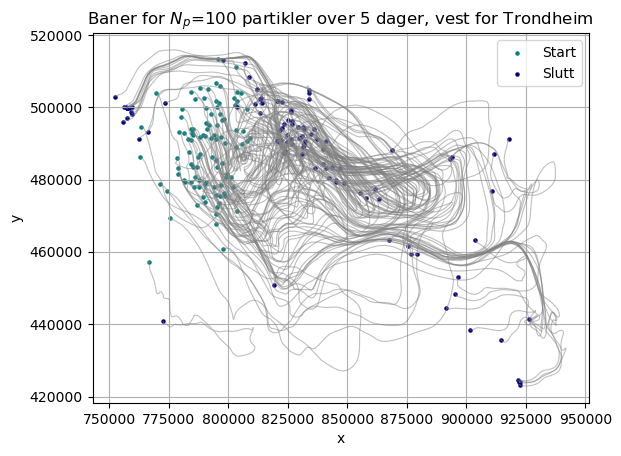

In [9]:
# Definerer konstanter
fw = 0.03   # vindfaktor
h = 3600    # steglengde [s]
Np = 100    # antall partikler, bestemt fra oppgave 1c
mean_x = 790000
mean_y = 490000
std_dev = 10000
t0 = 0
t_end = 5*24*3600

# Finner data for strømningene fra Norkyst-filen og bergener en funksjon utifra dataen
data = xr.open_dataset('NorKyst-800m-20240408-095558.nc')
f = Interpolator(dataset = data)

# Definerer initialbetingelser
X = np.zeros((Np, 2))
X[:,0] = np.random.normal(loc = mean_x, scale=std_dev, size = Np)
X[:,1] = np.random.normal(loc = mean_y, scale=std_dev, size = Np)

# Bruker heun() til å beregne banene til partiklene
tid, baner = heun2(X.T, t0, t_end, f, h)

# Plotter banene direkte i x- og y-koordinator
plt.plot(baner[:,0,:], baner[:,1,:], alpha = 0.5, lw = 0.8, color="grey")  

# Plotter start og sluttpunktene
plt.scatter(baner[0,0,:], baner[0,1,:], label="Start", color="teal", s=5)      # startposisjoner
plt.scatter(baner[-1,0,:], baner[-1,1,:], label="Slutt", color="navy", s=5)    # sluttposisjoner


plt.xlabel('x')
plt.ylabel('y')
plt.title('Baner for $N_p$=100 partikler over 5 dager, vest for Trondheim')
plt.legend()
plt.grid(True)
plt.show()

Her har vi valgt å plotte for $N_p = 100$ partikler, som vi anser som tilstrekkelig for å unngå lang kjøretid, samt sørge for at plottet ikke blir for rotete. Fra plottet ser man strømningslinjene, og at sluttposisjonene er mer spredt enn startposisjonene til partiklene.

### Oppgave 2b

Her plotter vi partikkelbaner med start- og sluttposisjoner på et kart, ved hjelp av utdelt eksempelkode. Vi plotter for tre ulike posisjoner utenfor norskekysten.

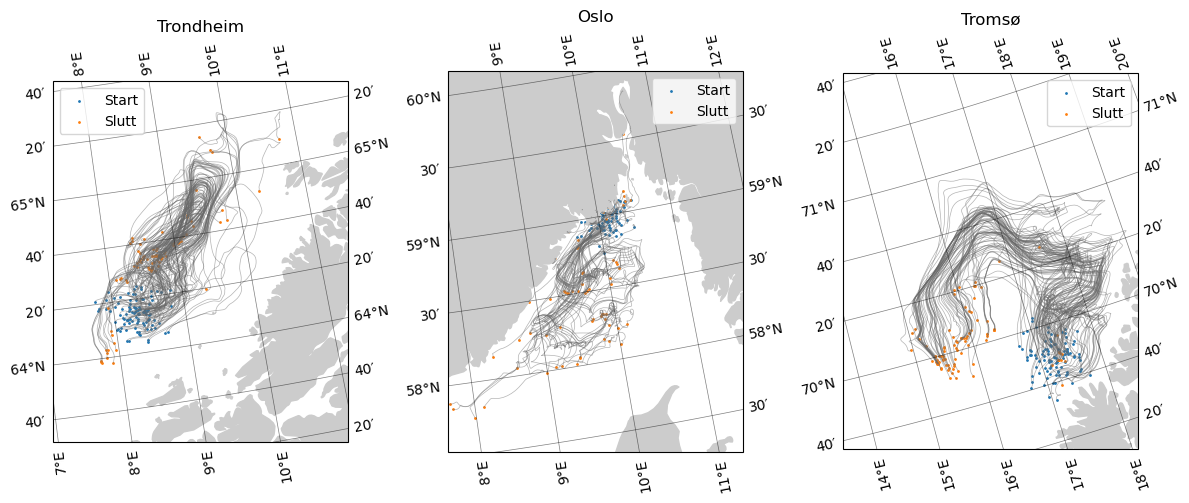

In [16]:
# Oppretter et projeksjonsobjekt for å konvertere partikkelposisjoner
npstere = ccrs.Stereographic(
    central_latitude = 90,
    central_longitude = f.dataset.projection_stere.straight_vertical_longitude_from_pole,
    false_easting = f.dataset.projection_stere.false_easting,
    false_northing = f.dataset.projection_stere.false_northing,
    true_scale_latitude = f.dataset.projection_stere.standard_parallel,
)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6), subplot_kw={'projection': ccrs.NorthPolarStereo()})

# Definerer konstanter felles konstanter
fw = 0.03   # vindfaktor
h = 3600    # steglengde [s]
Np = 100    # antall partikler, bestemt fra oppgave 1c
std_dev = 10000
t0 = 0
t_end = 5*24*3600

#------------------------------Trondheim------------------------------#

mean_x = 790000
mean_y = 490000

X = np.zeros((Np, 2))
X[:,0] = np.random.normal(loc = mean_x, scale=std_dev, size = Np)
X[:,1] = np.random.normal(loc = mean_y, scale=std_dev, size = Np)
tid, baner = heun2(X.T, t0, t_end, f, h)

ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', color = '#cccccc'))
# Plotter banene
ax1.plot(baner[:,0,:], baner[:,1,:], alpha = 0.5, lw = 0.5, transform=npstere, color="dimgrey")   
# Plotter start og sluttpunktene
ax1.scatter(baner[0,0,:], baner[0,1,:], s=1, transform=npstere, label='Start')         
# startposisjoner
ax1.scatter(baner[-1,0,:], baner[-1,1,:], s=1, transform=npstere, label='Slutt') 
# Gjør utklippet av kartet litt større
ax1.set_extent((7.5, 11, 63.5, 65.5))
# Legger til gridlines
gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=.5, color='k', lw=.5, )
ax1.legend()
ax1.set_title('Trondheim')

#------------------------------Oslo------------------------------#

mean_x = 330000
mean_y = 125000
# Create some positions
X = np.zeros((Np, 2))
X[:,0] = np.random.normal(loc = mean_x, scale = std_dev, size = Np)
X[:,1] = np.random.normal(loc = mean_y, scale = std_dev, size = Np)
tid, baner = heun2(X.T, t0, t_end, f, h)

ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', color = '#cccccc'))
# Plotter banene
ax2.plot(baner[:,0,:], baner[:,1,:], alpha = 0.5, lw = 0.5, transform=npstere, color="dimgrey")   
# Plotter start og sluttpunktene
ax2.scatter(baner[0,0,:], baner[0,1,:], s=1, transform=npstere, label='Start')         
# startposisjoner
ax2.scatter(baner[-1,0,:], baner[-1,1,:], s=1, transform=npstere, label='Slutt') 
# Gjør utklippet av kartet litt større
ax2.set_extent((8.2, 11.4, 57.5, 59.9))
# Legger til gridlines
gl = ax2.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=.5, color='k', lw=.5, )
ax2.legend()
ax2.set_title('Oslo')

#------------------------------Tromsø------------------------------#

mean_x = 1500000
mean_y = 500000
# Create some positions
X = np.zeros((Np, 2))
X[:,0] = np.random.normal(loc = mean_x, scale = std_dev, size = Np)
X[:,1] = np.random.normal(loc = mean_y, scale = std_dev, size = Np)
tid, baner = heun2(X.T, t0, t_end, f, h)

ax3.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', color = '#cccccc'))
# Plotter banene
ax3.plot(baner[:,0,:], baner[:,1,:], alpha = 0.5, lw = 0.5, transform=npstere, color="dimgrey")   
# Plotter start og sluttpunktene
ax3.scatter(baner[0,0,:], baner[0,1,:], s=1, transform=npstere, label='Start')         
# startposisjoner
ax3.scatter(baner[-1,0,:], baner[-1,1,:], s=1, transform=npstere, label='Slutt') 
# Gjør utklippet av kartet litt større
ax3.set_extent((14.8, 18.4, 69.5, 71.4))
# Legger til gridlines
gl = ax3.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=.5, color='k', lw=.5, )
ax3.legend()
ax3.set_title('Tromsø')

plt.tight_layout()
plt.show()

Ovenfor har vi plottet strømlinjer for 100 partikler henholdsvis vest for Trondheim, sør for Oslo og nord for Tromsø. Fra de ulike plottene ser vi at strømlinjene er ulike for hver lokasjon. 

### Oppgave 3

Videre ønsker vi å studere antall partikler som blir strandet ved å benytte funksjonen on_land() fra Interpolator-klassen fra utdelt kode. Denne funksjonen returnerer et array med 1'ere og 0'ere (True/False). For partikler som er på land blir returverdien True (=1). 

For å implementere bruken av on_land() oppretter vi en ny versjon av Heuns metode; heun3(). I heun3() finner vi for hvert tidssteg hvilke partikler som er på land ved å benytte f.on_land(). at_sea består av et array av 1'ere og 0'ere, der partikler som er strandet får verdi 0 (False), og partikler som fortsatt er på havet får verdi 1 (True). Videre settes pos, som benyttes i stedet for x i beregningen av k1 og k2, lik $x \cdot$at_sea. Slik kan partikler på havet kunne flytte seg videre, mens partikler som er strandet vil beholde samme posisjon. heun3() returnerer et array med tidene(t_array), et array med de beregnenede posisjonene (x_array), et array med andel partikler som er strandet ved hvert tidspunkt (on_land), samt et siste array (at_sea) som beskriver hvor mange partikler som er på havet ved slutt. 

In [13]:
def heun3(x0, t0, t_end, f, h):
    '''
    Heuns metode for å løse x' = f(x,t), x(t0) = x0
    '''
    if not isinstance(x0, np.ndarray): # dersom det skulle oppstå et skalarproblem: 
        x0 = np.array([x0])            # konverterer x0 til et numpy array
    if x0.size == 2:           # dersom det bare er en partikkel
        x0 = np.array([x0])    # oppretter et 2D-array for x der x0 er første element         
    
    t_array = np.arange(t0, t_end+0.0001, h)      # oppretter et 1D-array for t ∈ [t0, t_end]

    num_steps = len(t_array)    # henter størrelser som skal benyttes under
    Np = len(x0.T)

    x_array = np.zeros((num_steps+1, 2, Np))   # oppretter et 3D-array for x   
    x_array[0,:,:] += x0                       # der x0 er første element

    on_land = np.zeros_like(t_array)

    for i in range(num_steps):
        t = t_array[i]        # henter verdien fra t-arrayet for dette steget 
        x = x_array[i,:,:]    # henter riktig element i x-arrayet, dvs. et array med Np x- og y-koordinater

        at_sea = np.ones_like(x) - f.on_land(x)   # = 1 for partikler på havet, = 0 for strandede partikler

        # utfører Heuns metode 
        k1 = f(x, t)                        
        k2 = f(x + h*k1, t+h)
        x_ny = x + 0.5 * h * (k1 + k2) * at_sea    # dersom partiklene er strandet endres ikke posisjonen

        x_array[i+1, :, :] += x_ny     # legger til de nye verdiene

        on_land[i] += (1 - np.mean(at_sea))  # andel partikler som er strandet på dette tidspunktet

    return t_array, x_array, on_land, at_sea

### Oppgave 3a

Under plotter vi fordelingen av plastpartikler etter tre dager. Partikler får ulik farge ut fra om de er strandet eller ikke. Dersom en partikkel har kommet på land, blir den værende på land. Vi plotter også prosentandelen strandede partikler som funksjon av tid.

Her har vi valgt å plotte for $N_p = 100$ partikler, som vi anser som tilstrekkelig med tanke på kjøretid, og for å gjøre plottet oversiktlig. 

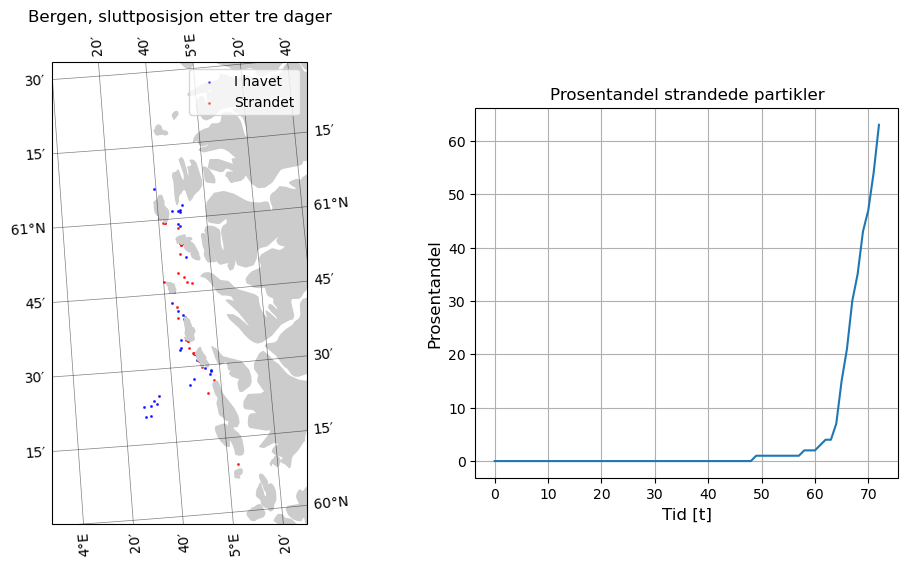

In [14]:
d = xr.open_dataset('NorKyst-800m-20240408-095558.nc')

f = Interpolator(dataset=d, fw=0.03)

# Setter initialbetingelser og steglengde
h = 3600  # Steglengde 1 time
Np = 100 
mean_x = 250000  # Oppgitte verdier
mean_y = 460000
std_dev = 10000  # standardavvik
t0 = 0
t_end = 3 * 24 * 3600  # tre dager

# Initialposisjon
P = np.zeros((Np, 2))  # Array med arrays som inneholder posisjoner
P[:, 0] = np.random.normal(loc=mean_x, scale=std_dev, size=Np)
P[:, 1] = np.random.normal(loc=mean_y, scale=std_dev, size=Np)

# Heuns metode, prosentandel partikler på land og hvilke partikler som er på havet ved slutt
t, X, total_on_land, sea_particles = heun3(P.T, t0, t_end, f, h)

# De partiklene som er på land ved slutt får verdi 1 i land_praticles
land_particles = np.ones_like(sea_particles) - sea_particles

# Konverter tid fra sekunder til timer
t_hours = t / 3600  # Konverterer fra sekunder til timer

# Oppretter projeksjonsobjekt for å konvertere partikkelposisjoner
npstere = ccrs.Stereographic(
    central_latitude = 90,
    central_longitude = f.dataset.projection_stere.straight_vertical_longitude_from_pole,
    false_easting = f.dataset.projection_stere.false_easting,
    false_northing = f.dataset.projection_stere.false_northing,
    true_scale_latitude = f.dataset.projection_stere.standard_parallel,
)


# Definerer figurer og akser
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', color='#cccccc'))

# Plotter sluttposisjonen til partiklene
ax1.scatter(X[-1, 0,:] * sea_particles.astype(int), X[-1, 1,:] * sea_particles.astype(int), c='blue', alpha=0.5, transform=npstere, label='I havet', s=1)
ax1.scatter(X[-1, 0,:] * land_particles.astype(int), X[-1, 1,:] * land_particles.astype(int), c='red', alpha=0.5, transform=npstere, label='Strandet', s=1)


# Gjør outline større
ax1.set_extent((4, 5.5, 60, 61.5))
# Legger til gridlines
gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=.5, color='k', lw=.5, )

ax1.legend()
ax1.set_title('Bergen, sluttposisjon etter tre dager')

#Plotter prosentandel stranda partikler som funksjon av tid
ax2.plot(t_hours, total_on_land * 100, linestyle='-')
ax2.set_xlabel('Tid [t]', fontsize=12)
ax2.set_ylabel('Prosentandel', fontsize=12)
ax2.set_title('Prosentandel strandede partikler')
ax2.xaxis.set_visible(True)
ax2.yaxis.set_visible(True)
ax2.grid(True)

plt.show()

Plottene viser fordelingen av partiklene; på land og i havet. Partiklene holder seg på havet over lang tid, men de siste 10 timene øker prosentandelen partikler på land fra 0 til 50%. Dette tyder på at partiklene beveger seg nokså likt inn mot land, som kommer av at de har startposisjon i samme område og følger samme havstrømmer.

### Oppgave 3b

Her studerer vi hvordan prosentandelen av strandede partikler varierer med ulike verdier av $f_w$, vindfaktorer, som varierer for ulike typer plast. Vi ser på verdier av $f_w$ fra $0$ til $0.15$ .

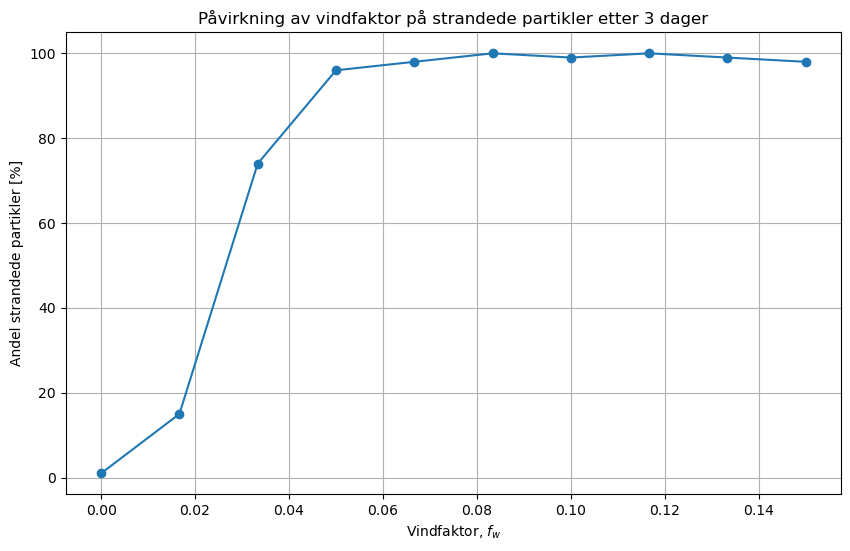

In [15]:
# Åpner datasettet
d = xr.open_dataset('NorKyst-800m-20240408-095558.nc')

def simulate_and_plot(fW):
    # Setter initialbetingelser og steglengde
    h = 3600  # Steglengde 1 time
    Np = 100  # Må finne er passelig verdi og begrunne
    mean_x = 250000  # Oppgitte verdier
    mean_y = 460000
    std_dev = 10000  # standard deviation
    t0 = 0
    t_end = 3 * 24 * 3600  # tre dager
    
    f = Interpolator(dataset = d, fw = fW)

    x = np.random.normal(mean_x, std_dev, Np)
    y = np.random.normal(mean_y, std_dev, Np)
    init = np.column_stack((x, y))  

    # Heuns metode
    t, X, total_on_land, sea_particles = heun3(init.T, t0, t_end, f, h)
    
    # Beregner prosentandel av partikler som blir strandet etter tre dager
    percentage_stranded = total_on_land[-1] * 100

    return percentage_stranded

# Tester for ulike vindfaktorer
fw_values = np.linspace(0, 0.15, 10)
stranded_percentages = []

for fw in fw_values:
    stranded_percentage = simulate_and_plot(fw)
    stranded_percentages.append(stranded_percentage)

# Plot resultatene
plt.figure(figsize=(10, 6))
plt.plot(fw_values, stranded_percentages, marker='o')
plt.xlabel('Vindfaktor, $f_w$')
plt.ylabel('Andel strandede partikler [%]')
plt.title('Påvirkning av vindfaktor på strandede partikler etter 3 dager')
plt.grid(True)
plt.show()

Plottet ovenfor viser prosentandel strandede partikler som funksjon av vindfaktor, $f_w$. Som man kan se i plottet, vil andelen partikler som har kommet til land etter tre dager i hovedsak øke for økende vindfaktor. Dette er ikke overraskende da vinden ofte blåser mot land, og dermed bidrar til at partikler med høyrere vindfaktor blir brakt raskere til land. For $f_w \in [0.05, 0.15]$ er resultatene ganske like, og nesten alle partiklene har endt på land. Altså skal det ikke store vindfaktoren til før partiklene blir påvirket i såpass stor grad av vinden at de blir strandet.


### Oppsummering

I dette prosjektet har vi sett på transport av partikler med havstrømmer. Vi implementerte Heuns metode og tilpasset denne for bestemte problemstillinger. Videre testet vi ulike steglengder i Heuns metode og bereget banene til partikler med ulik startposisjon. Deretter ble effektiviteten til koden sjekket, og kjøretiden for ulikt antall partikler plottet. I påfølgende oppgave ble strømlinjene til ulike partikler beregnet ved å benytte interpolasjon på utdelt data. Resultatene ble plottet på kart for tre ulike steder langs norskekysten. Så ble sluttposisjonene til partiklene studert. Til slutt undersøkte vi andel partikler som ble strandet med ulike vindfaktorer. 